# Checking every step of preprocessing

### Imports

In [1]:
from plots import before_after_plot, plot_mean_welch
from get_bads import get_bad_epochs, get_bad_channels
from preprocess import preprocess

import mne
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss
mne.set_log_level(verbose='CRITICAL')

### First step: reading data (using mne)

In [2]:
participant = 'm1'
file = mne.io.read_raw_eeglab('./data2/'+participant+'.set', preload=True)
before_ref = file.get_data() #extracting data before setting refrence channels to see any changes

'''Setting refrence channels (ears)'''
file.set_eeg_reference(ref_channels=['A1','A2']) 
after_ref = file.get_data() #extracting data after setting refrence (checking changes)

'''Dropping (removing) redundant channels'''
file.drop_channels(['EOG','dioda','TSS','A1','A2'])

<RawEEGLAB | m1.fdt, 19 x 4939296 (4823.5 s), ~716.0 MB, data loaded>

Plotting changes for refrence channels

https://mne.tools/dev/generated/mne.set_eeg_reference.html

It uses average in default

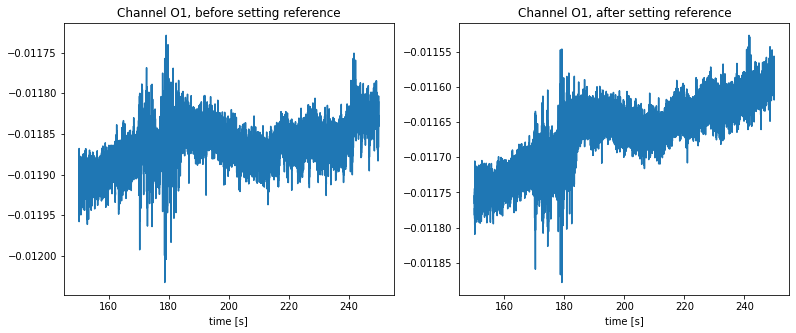

In [3]:
Fs = int(file.info['sfreq'])
channels = file.info['ch_names']
ch = 0

before_after_plot(before_ref, after_ref, Fs, ch, channels[ch], name = 'setting reference')

### Second step: Filtering

#### Checking impulse response

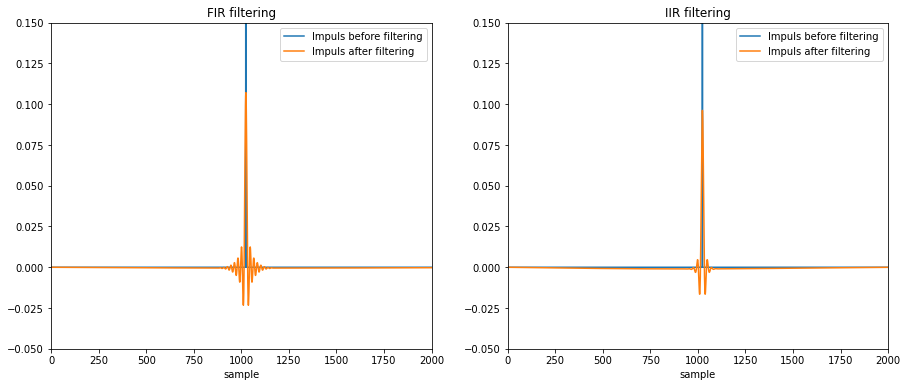

In [4]:
mne.set_log_level(verbose='CRITICAL')
'''FIR method'''
impulse = np.zeros(10*Fs)
impulse[1*Fs] = 1
impulse[5*Fs] = 1
impulse[8*Fs] = 1
filt_imp = mne.filter.filter_data(impulse,Fs,0.5,49) #default is fir method

plt.figure(figsize = (15,6))

plt.subplot(1,2,1)
plt.xlim(0,2000)
plt.ylim(-0.05,0.15)
plt.plot(impulse, label = 'Impuls before filtering')
plt.plot(filt_imp, label = 'Impuls after filtering')
plt.xlabel('sample')
plt.title('FIR filtering')
plt.legend(loc = 'upper right')

'''IIR method'''
impulse = np.zeros(10*Fs)
impulse[1*Fs] = 1
impulse[5*Fs] = 1
impulse[8*Fs] = 1
filt_imp = mne.filter.filter_data(impulse,Fs,0.5,49,method='iir',iir_params=dict(order=5, ftype='butter'))

plt.subplot(1,2,2)
plt.xlim(0,2000)
plt.ylim(-0.05,0.15)
plt.plot(impulse, label = 'Impuls before filtering')
plt.plot(filt_imp, label = 'Impuls after filtering')
plt.title('IIR filtering')
plt.xlabel('sample')
plt.legend(loc = 'upper right')
plt.show()

### Maybe IIR mehod will be better because of shorter impulse response?

## Filtering data

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 49 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 0.50, 49.00 Hz: -6.02, -6.02 dB

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 sec)



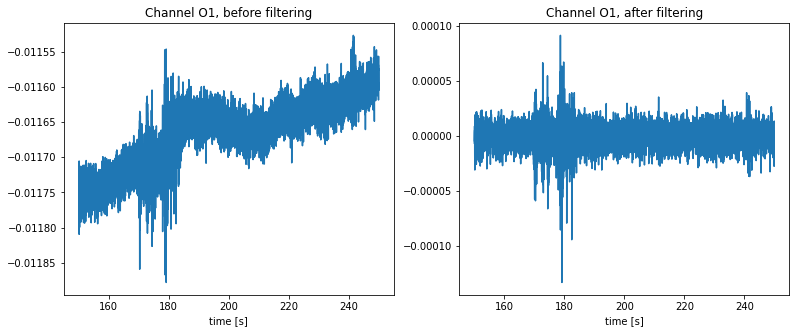

In [5]:
mne.set_log_level(verbose=None) #for mne to tell us specification of filters

before_filtering = after_ref

file.filter(0.5,49,method='iir',iir_params=dict(order=5, ftype='butter'))
file.notch_filter(np.arange(50, 251, 50),method='fir')

after_filtering = file.get_data()

before_after_plot(before_filtering, after_filtering, Fs, ch, channels[ch], name = 'filtering')

## Interpolating

https://mne.tools/dev/overview/implementation.html#channel-interpolation

Computing interpolation matrix from 15 sensor positions
Interpolating 4 sensors


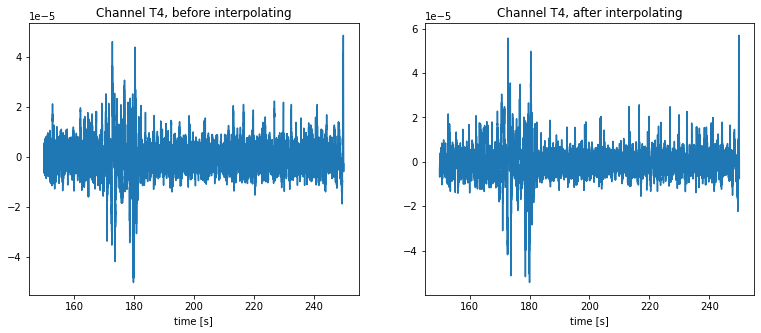

In [6]:
before_interp = after_filtering

ch_bads, ch_names = get_bad_channels(before_interp, channels)
file.info['bads'] = ch_names
file.interpolate_bads(reset_bads=False, mode='accurate', origin=[0,0,0])

after_interp = file.get_data()
bad_ch = ch_bads[1]

before_after_plot(before_interp, after_interp, Fs, bad_ch, channels[bad_ch], name = 'interpolating')

## Downsampling

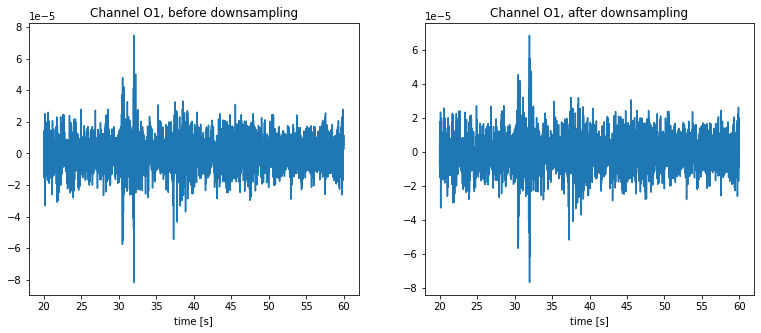

In [7]:
before_resamp = after_interp

file.resample(256)

after_resamp = file.get_data()

Fs_d = int(file.info['sfreq'])

before_after_plot(before_resamp, after_resamp,Fs, ch, channels[ch], name = 'downsampling', start = 20, stop = 60, Fs_new = Fs_d)

## Epochs preprocessing

#### Marking events

In [8]:
ile = len(file.event['latency'])
EVENTS = np.zeros((ile,3))
EVENTS[:,0] = file.event['latency']
EVENTS[:,1] = 0
EVENTS[:,2] = 1
EVENTS = EVENTS/4

In [9]:
ile

1635

#### Dropping bad trials

In [14]:
mne.set_log_level(verbose='CRITICAL')
epo = mne.Epochs(file, EVENTS.astype(int), metadata = pd.DataFrame(file.event['tag_type']), 
                 tmin= -0.2, tmax=1, preload=True)
before_drop = epo.get_data()
mistakes = np.array([True if i['word_type']!=i['decision'] else False for i in file.event['tag_type']])
mistakes[get_bad_epochs(before_drop).astype(int)] = True
bad_ch = mistakes

epo.drop(bad_ch)

<Epochs  |   931 events (all good), -0.199219 - 1 sec, baseline [None, 0], ~41.6 MB, data loaded, with metadata,
 '0': 931>

In [15]:
bad_epochs = before_drop[np.where(mistakes==True)[0]]
good_epochs = epo.get_data()
good_epochs.shape, bad_epochs.shape

((931, 19, 308), (704, 19, 308))

## Bad epoch checking

### Checking for big values (treshold) - comparing with outcome in good epochs

In [16]:
count = 0
treshold = 5 * 10**(-5)
for i in range(bad_epochs.shape[0]):
    for ch in range(19):
        test = np.abs(bad_epochs[i,ch,:]) > treshold
        if test.any():
            count +=1
print(count)

70


### Mean spectrum power for bad epochs, for each channel

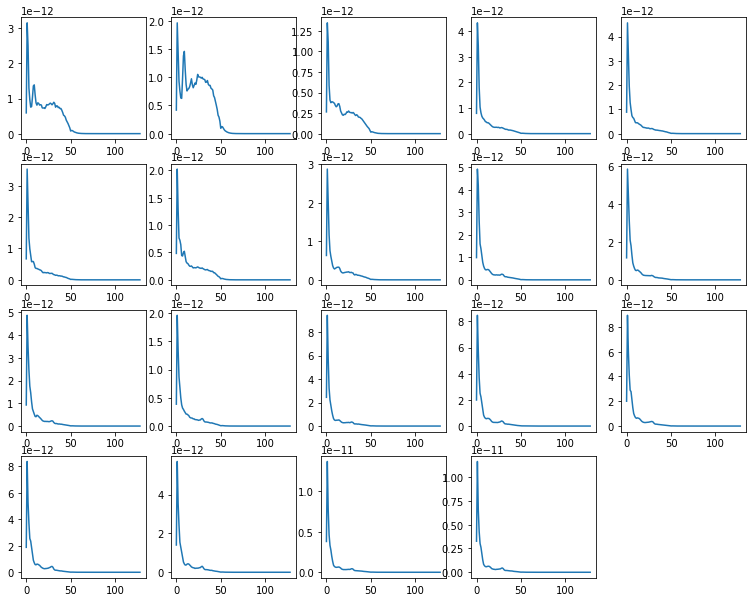

In [17]:
f, welch = ss.welch(bad_epochs, fs = Fs_d)
mean_welch = np.mean(welch, axis = 0)

plt.figure(figsize=(13,13))
c = 1
for i in range(1,6):
    if c == 20:
        break
    for j in range(1,6):
        if c == 20:
            break
        plt.subplot(5,5,c)
        plt.plot(f, mean_welch[c-1, :])
        c += 1

plt.show()

### Checking for big values (treshold) - comparing with outcome from bad epochs

In [18]:
count = 0
treshold = 5 * 10**(-5)
for i in range(good_epochs.shape[0]):
    for ch in range(19):
        test = np.abs(good_epochs[i,ch,:]) > treshold
        if test.any():
            count +=1
print(count)

0


It looks like marking bad channels is somehow correlated with very high values in them. Propably because of peaks in signal.

### Mean spectrum power for good epochs, for each channel

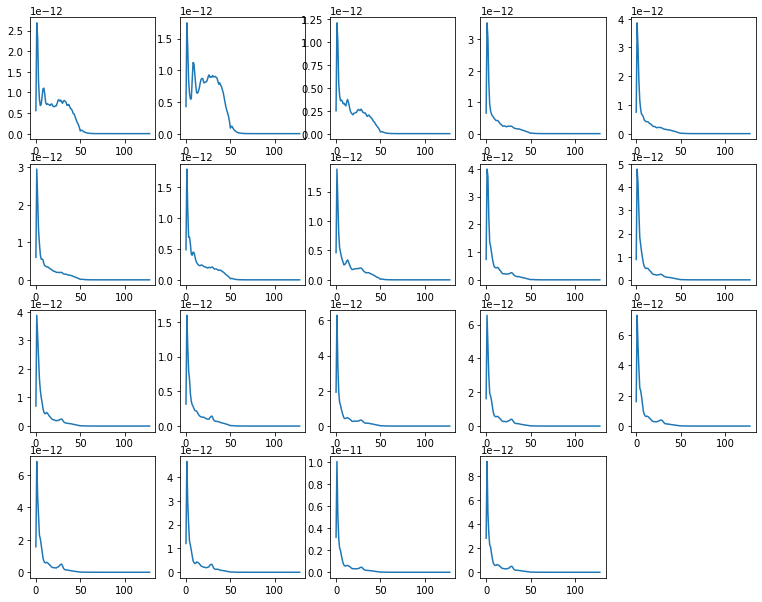

In [19]:
f, welch = ss.welch(good_epochs, fs = Fs_d)
mean_welch = np.mean(welch, axis = 0)

plt.figure(figsize=(13,13))
c = 1
for i in range(1,6):
    if c == 20:
        break
    for j in range(1,6):
        if c == 20:
            break
        plt.subplot(5,5,c)
        plt.plot(f, mean_welch[c-1, :])
        c += 1

plt.show()

#### Params

In [20]:
samples = len(epo._raw_times)
time = epo._raw_times
trials_count = len(epo.selection)
nchan = epo.info['nchan']

## Extracting frequency bands from epochs

In [21]:
mne.set_log_level(verbose=None)

no_bands = 5
method = 'iir'
epoki = np.empty((no_bands, trials_count, nchan, samples))

epoki[0] = epo.copy().filter(0.5,4,method=method,iir_params=dict(order=5, ftype='butter')).get_data()
epoki[1] = epo.copy().filter(4,9,method=method,iir_params=dict(order=5, ftype='butter')).get_data()
epoki[2] = epo.copy().filter(9,14,method=method,iir_params=dict(order=5, ftype='butter')).get_data()
epoki[3] = epo.copy().filter(14,30,method=method,iir_params=dict(order=5, ftype='butter')).get_data()
epoki[4] = epo.copy().filter(30,49,method=method,iir_params=dict(order=5, ftype='butter')).get_data()

Setting up band-pass filter from 0.5 - 4 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 0.50, 4.00 Hz: -6.02, -6.02 dB

Setting up band-pass filter from 4 - 9 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 4.00, 9.00 Hz: -6.02, -6.02 dB

Setting up band-pass filter from 9 - 14 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 9.00, 14.00 Hz: -6.02, -6.02 dB

Setting up band-pass filter from 14 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (ef

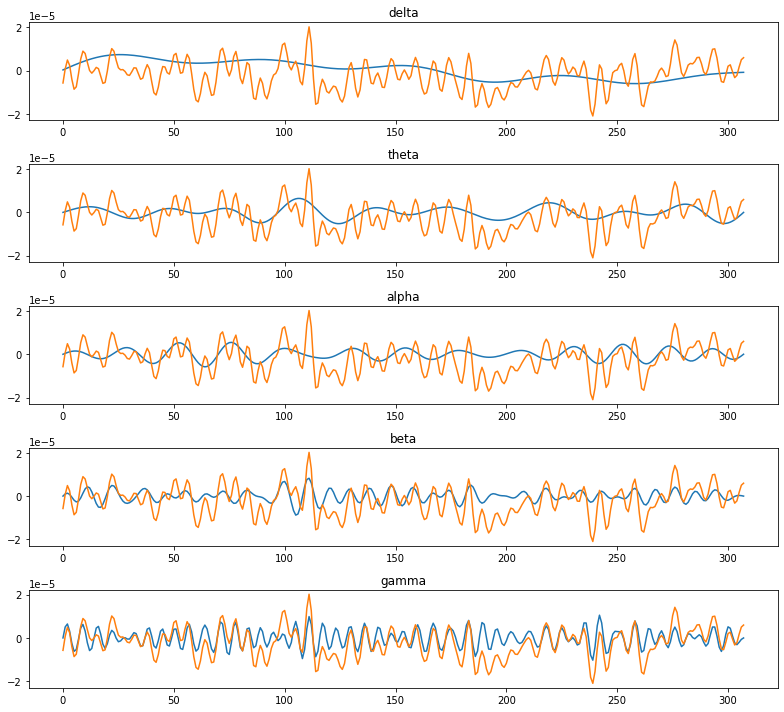

In [22]:
plt.figure(figsize = (11,10))
band_names = ('delta','theta','alpha','beta','gamma')
epo_before = epo.get_data()

for i in range(no_bands):
    plt.subplot(no_bands,1,i+1)
    plt.title(band_names[i])
    plt.plot(epoki[i,0,0,:])
    plt.plot(epo_before[0,0,:])
plt.tight_layout()
plt.show()

## Hilber envelope + tukey window

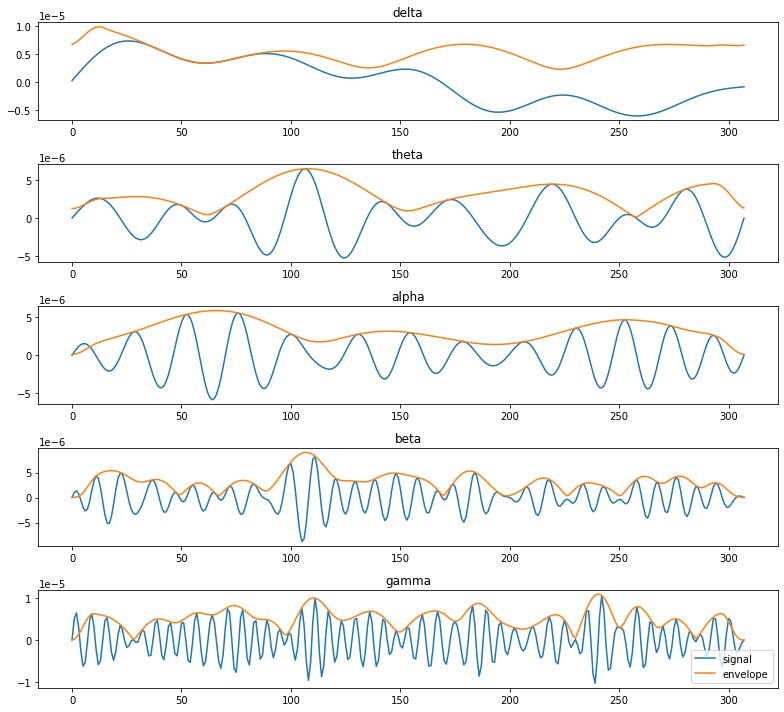

In [23]:
plt.figure(figsize = (11,10))
end_point = int(0.2*Fs_d)
alpha = 0.1
hilb_epo = epoki.copy()
nepo = 0
nch = 0
samples = hilb_epo.shape[-1]
for i in range(no_bands):
    window = ss.tukey(samples, alpha)
    hilb_epo[i,:,:,:] = np.abs(ss.hilbert(hilb_epo[i,:,:,:] * window , axis = -1))
    hilb_i = hilb_epo[i,nepo,nch,:]
    plt.subplot(no_bands,1,i+1)
    plt.title(band_names[i])
    plt.plot(epoki[i,nepo,nch,:], label = 'signal')
    plt.plot(hilb_i, label = 'envelope')
    alpha = alpha * 0.9
plt.legend()
plt.tight_layout()
plt.show()

## Baseline correction

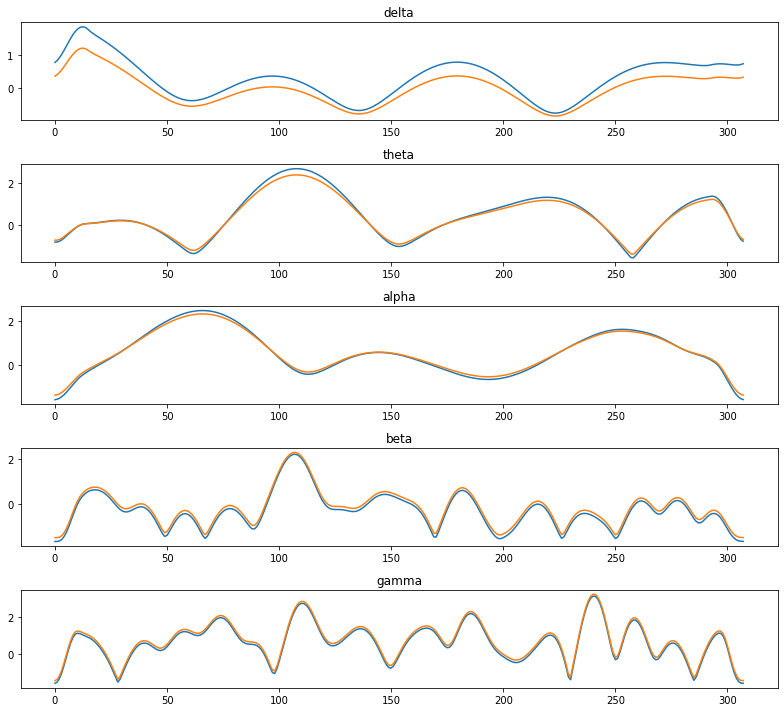

In [24]:
plt.figure(figsize = (11,10))
end_point = int(0.2*Fs_d)
hilb_epo_base = hilb_epo.copy()
hilb_epo_base = (hilb_epo_base - np.mean(hilb_epo_base[:,:,:,:end_point], axis = (1,3)).reshape(5,1,19,1) ) / np.std(hilb_epo_base[:,:,:,:end_point], axis = (1,3)).reshape(5,1,19,1)
hilb_epo_base2 = hilb_epo.copy()
hilb_epo_base2 = (hilb_epo_base - np.mean(hilb_epo_base, axis = (1,3)).reshape(5,1,19,1) ) / np.std(hilb_epo_base, axis = (1,3)).reshape(5,1,19,1)

for i in range(no_bands):
    norm_i = hilb_epo_base[i,nepo,nch,:]
    plt.subplot(no_bands,1,i+1)
    plt.plot(hilb_epo_base2[i,nepo,nch,:])
    plt.title(band_names[i])
    plt.plot(norm_i)
    
plt.tight_layout()
plt.show()

## Mean welch - whole participant

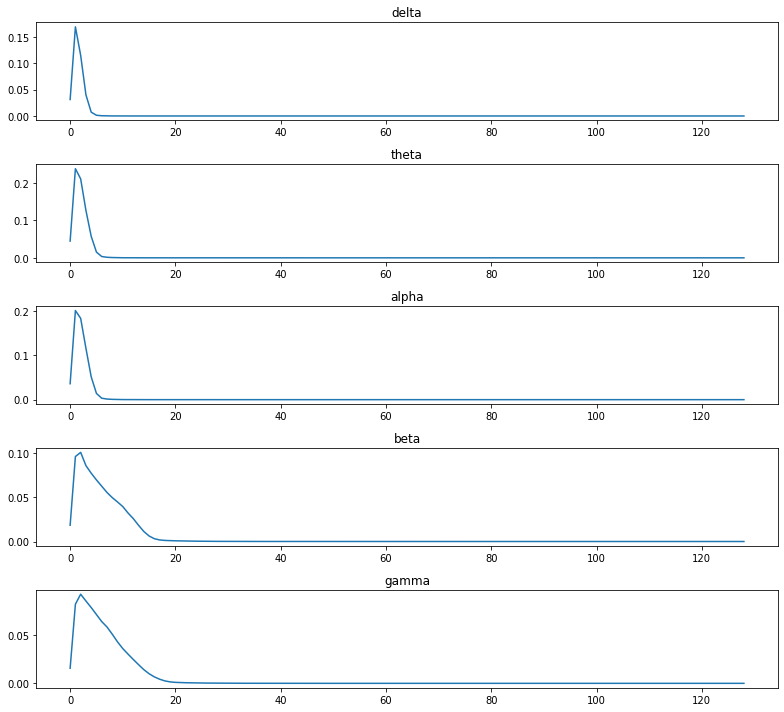

In [25]:
plot_mean_welch(hilb_epo_base, Fs_d, band_names) 

## Resampling vol 2

<Figure size 792x720 with 0 Axes>

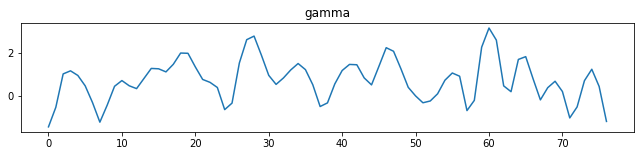

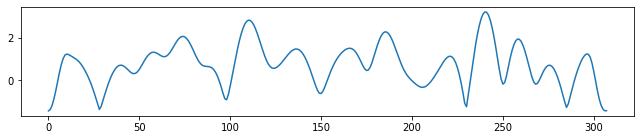

<Figure size 432x288 with 0 Axes>

In [26]:
plt.figure(figsize = (11,10))
end_point = int(0.2*Fs)
epo_final = mne.filter.resample(hilb_epo_base.copy(), up = 1, down = 4)
for i in range(4,no_bands):
    plt.figure(figsize = (11,2))
    plt.title(band_names[i])
    plt.plot(epo_final[i,nepo,nch,:])
    plt.show()
    plt.figure(figsize = (11,2))
    plt.plot(hilb_epo_base[i,nepo,nch,:])
    plt.show()
plt.tight_layout()
plt.show()
FS = Fs_d//4